<a href="https://colab.research.google.com/github/CPJKU/partitura_tutorial/blob/main/content/Partitura_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to Symbolic Music Processing with Partitura

Partitura is python 3 package for symbolic music processing developed and maintained at OFAI Vienna / CP JKU Linz (and other contributors). It's inteded to give a lightweight musical part representation that makes many score properties easily accessible for a variety of tasks. Furthermore it's a very useful I/O utility to parse computer formats of symbolic music. 

## 1. Install and import

Partitura is available in github https://github.com/CPJKU/partitura

You can install it with `pip install partitura`.

However if you are interested in features that still have to be officially released, it's better to install the develop branch.

In [1]:
# Install partitura
! pip install partitura
    
# To be able to access helper modules in the repo for this tutorial
# (not necessary if the jupyter notebook is run locally instead of google colab)
!git clone https://github.com/CPJKU/partitura_tutorial.git
    
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), "partitura_tutorial", "content"))
sys.path.insert(0,'/content/partitura_tutorial/content')


fatal: destination path 'partitura_tutorial' already exists and is not an empty directory.


In [2]:
import glob
import partitura as pt
import numpy as np
import matplotlib.pyplot as plt

#### Dataset for this tutorial

In this tutorial we are going to use the [Vienna 4x22 Corpus](https://repo.mdw.ac.at/projects/IWK/the_vienna_4x22_piano_corpus/index.html) which consists of performances of 4 classical piano pieces, which have been aligned to their corresponding scores.

The dataset contains:

* Scores in MusicXML format (4 scores)
* Performances in MIDI files (88 in total, 22 performances per piece, each by a different pianist)
* Score to performance alignments in Match file format (88 in total one file per performance)

In [3]:
# setup the dataset
from load_data import init_dataset
DATASET_DIR = init_dataset()
MUSICXML_DIR = os.path.join(DATASET_DIR, 'musicxml')
MIDI_DIR = os.path.join(DATASET_DIR, 'midi')
MATCH_DIR = os.path.join(DATASET_DIR, 'match')

Output()

## 2. Loading and Exporting Files

One of the main use cases of partitura is to load and export common symbolic music formats.

### Supported Formats

#### Reading

##### Symbolic Scores

These methods return a `Part`, a `PartGroup` or a list of `Part` objects.

|Format| Method|Notes|
|:---|:---|:---|
|MusicXML| `partitura.load_musicxml`| |
|MIDI| `partitura.load_score_midi`|Pitch spelling, key signature (optional) and other information is inferred with methods in `partitura.musicanalysis`. 
|MEI| `partitura.load_mei`|
|Humdrum Kern| `partitura.load_kern`|
|MuseScore|`partitura.load_via_musescore`| Requires [MuseScore](https://musescore.org/en). Loads all formats supported by MuseScore. Support on Windows is still untested.

##### Symbolic Performances

These methods return a `PerformedPart`.

|Format| Method|Notes|
|:---|:---|:---|
|MIDI|`partitura.load_performance_midi`| Loads MIDI file as a performance, including track, channel and program information. Time signature and tempo information are only used to compute the time of the MIDI messages in seconds. Key signature information is ignored

##### Alignments

These methods return score-to-performance alignment (discussed below).

|Format| Method|Notes|
|:---|:---|:---|
|Match file| `partitura.load_match`| Returns alignment, a performance as `PerformedPart` and optionally a `Part`. See usage below.
|Nakamura et al. corresp file | `partitura.load_nakamuracorresp`|
|Nakamura et al. match file| `partitura.load_nakamuramatch`|

#### Writing

##### Symbolic Scores

Support for MEI and Humdrum Kern is coming!

|Format| Method|Notes|
|:---|:---|:---|
|MusicXML| `partitura.save_musicxml`|
|MIDI| `partitura.save_score_midi`| Includes Key signature, time signature and tempo information.

##### Symbolic Performances
|Format| Method|Notes|
|:---|:---|:---|
|MIDI|`partitura.save_performance_midi`| Does not include key signature or time signature information

##### Alignments

A companion library for music alignment is in preparation!

|Format| Method|Notes|
|:---|:---|:---|
|Match file| `partitura.save_match`| 


## 3. Internal Representations

### 3.1 The Part Object

The ```part``` object is the central object of partitura. It contains a score.
- it is a timeline object
- time is measured in divs
- its elements are timed objects, i.e. they have a starting time and an ending time
- external score files are loaded into a part
- parts can be exported into score files
- it contains many useful methods related to its properties

Here's a visual representation of the ```part``` object representing the first measure of Chopin's Nocturne Op. 9 No. 2

![Timeline_chopin2.png](https://github.com/CPJKU/partitura_tutorial/raw/main/static/Timeline_chopin2.png)

In [4]:
path_to_musicxml = pt.EXAMPLE_MUSICXML
part = pt.load_musicxml(path_to_musicxml)[0]
print(part.pretty())

Part id="P1" name="Piano"
 │
 ├─ TimePoint t=0 quarter=12
 │   │
 │   └─ starting objects
 │       │
 │       ├─ 0--48 Measure number=1
 │       ├─ 0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
 │       ├─ 0--48 Page number=1
 │       ├─ 0--24 Rest id=r01 voice=2 staff=1 type=half
 │       ├─ 0--48 System number=1
 │       └─ 0-- TimeSignature 4/4
 │
 ├─ TimePoint t=24 quarter=12
 │   │
 │   ├─ ending objects
 │   │   │
 │   │   └─ 0--24 Rest id=r01 voice=2 staff=1 type=half
 │   │
 │   └─ starting objects
 │       │
 │       ├─ 24--48 Note id=n02 voice=2 staff=1 type=half pitch=C5
 │       └─ 24--48 Note id=n03 voice=2 staff=1 type=half pitch=E5
 │
 └─ TimePoint t=48 quarter=12
     │
     └─ ending objects
         │
         ├─ 0--48 Measure number=1
         ├─ 0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
         ├─ 24--48 Note id=n02 voice=2 staff=1 type=half pitch=C5
         ├─ 24--48 Note id=n03 voice=2 staff=1 type=half pitch=E5
         ├─ 0--48 Page number=

![score_example.png](https://github.com/CPJKU/partitura_tutorial/raw/main/static/score_example.png)

### Part Notes

Each ```part``` object contains a list notes. Notes inherit from the ```TimedObject``` class. Like all ```TimedObjects``` they contain a (possibly coincident) start time and end time, encoded as ```TimePoint``` objects.

In [5]:
part.notes

In [6]:
dir(part.notes[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ref_attrs',
 '_sym_dur',
 'alter',
 'alter_sign',
 'articulations',
 'beam',
 'doc_order',
 'duration',
 'duration_from_symbolic',
 'duration_tied',
 'end',
 'end_tied',
 'fermata',
 'id',
 'iter_chord',
 'midi_pitch',
 'octave',
 'ornaments',
 'replace_refs',
 'slur_starts',
 'slur_stops',
 'staff',
 'start',
 'step',
 'symbolic_duration',
 'tie_next',
 'tie_next_notes',
 'tie_prev',
 'tie_prev_notes',
 'tuplet_starts',
 'tuplet_stops',
 'voice']

You can create notes (without timing information) and then add it to a part by specifying start and end times (in divs!). Use each note object only once! You can remove notes from a part.

In [7]:
a_new_note = pt.score.Note(id='n04', step='A', octave=4, voice=1)
part.add(a_new_note, start=3, end=15)
# print(part.pretty())

In [8]:
part.remove(a_new_note)
# print(part.pretty())

### Converting from divs to musical units and back

Integer divs are useful for encoding scores but unwieldy for human readers. Partitura offers a variety of ```*unit*_maps``` from the timeline unit "div" to musical units such as "beats" (in two different readings) or "quarters". For the inverse operation the corresponding ```inv_*unit*_map``` exist as well. Quarter to div ratio is a fixed value for a ```part``` object, but units like beats might change with time signature, so these ```maps``` are implemented as ```part``` methods.

Let's look at how to get the ending position in beats of the last note in our example ```part```.

In [9]:
part.beat_map(part.notes[0].end.t)

array(4.)

Some musical information such as key and time signature is valid for a segment of the score but only encoded in one location. To retrieve the "currently active" time or key signature at any score position, ```maps``` are available too.

In [10]:
part.time_signature_map(part.notes[0].end.t)

array([4., 4., 4.])

### Iterating over arbitrary musical objects in a part

The ```part``` class contains a central method ```iter_all``` to iterate over all instances of the ```TimedObject``` class or its subclasses of a part. The ```iter_all``` method returns an iterator and takes five optional parameters: 
- A ```TimedObject``` subclass whose instances are returned. You can find them all in the partitura/partitura/score.py file. Default is all classes.
- A ```include_subclasses``` flag. If true, instances of subclasses are returned too. E.g. ``` part.iter_all(pt.score.TimedObject, include_subclasses=True)``` returns all objects or ```part.iter_all(pt.score.GenericNote, include_subclasses=True)``` returns all notes (grace notes, standard notes)
- A start time in divs to specify the search interval (default is beginning of the part)
- An end time in divs to specify the search interval (default is end of the part)
- A ```mode``` parameter to define whether to search for starting or ending objects, defaults to starting.

In [11]:
for measure in part.iter_all(pt.score.Measure):
    print(measure)

0--48 Measure number=1


In [12]:
for note in part.iter_all(pt.score.GenericNote, include_subclasses=True, start=0, end=24):
    print(note)

0--48 Note id=n01 voice=1 staff=2 type=whole pitch=A4
0--24 Rest id=r01 voice=2 staff=1 type=half


### Example: Adding a new measure and a note at its downbeat

Let's use class retrieval, time mapping, and object creation together and add a new measure with a single beat-length note at its downbeat. This code works even if you know nothing about the underlying score.

In [13]:
# figure out the last measure position, time signature and beat length in divs
measures = [m for m in part.iter_all(pt.score.Measure)]
last_measure_number = measures[-1].number
append_measure_start =  measures[-1].end.t 
Last_measure_ts = part.time_signature_map(append_measure_start)

Last_measure_ts = part.time_signature_map(append_measure_start)
one_beat_in_divs_at_the_end = append_measure_start - part.inv_beat_map(part.beat_map(append_measure_start)-1)
append_measure_end = append_measure_start +  one_beat_in_divs_at_the_end*Last_measure_ts[0]

# add a measure
a_new_measure = pt.score.Measure(number = last_measure_number+1)
part.add(a_new_measure, start=append_measure_start, end=append_measure_end)
# add a note
a_new_note = pt.score.Note(id='n04', step='A', octave=4, voice=1)
part.add(a_new_note, start=append_measure_start, end=append_measure_start+one_beat_in_divs_at_the_end)

In [14]:
# print(part.pretty())

### 3.2 The PerformedPart Object

The ```PerformedPart``` class is a wrapper for MIDI files. Its structure is much simpler:
- a notes property that consists of list of MIDI notes as dictionaries
- a controls property that consists of list of MIDI CC messages
- some more utility methods and properties

In [15]:
path_to_midifile = pt.EXAMPLE_MIDI
performedpart = pt.load_performance_midi(path_to_midifile)[0]

In [16]:
performedpart.notes

[{'midi_pitch': 69,
  'note_on': 0.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 1,
  'velocity': 64,
  'id': 'n0',
  'sound_off': 2.0},
 {'midi_pitch': 72,
  'note_on': 1.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 2,
  'velocity': 64,
  'id': 'n1',
  'sound_off': 2.0},
 {'midi_pitch': 76,
  'note_on': 1.0,
  'note_off': 2.0,
  'track': 0,
  'channel': 2,
  'velocity': 64,
  'id': 'n2',
  'sound_off': 2.0}]

### 3.3 Tiny example with cats on keyboards

In [17]:
import numpy as np 

def addnote(midipitch, part, voice, start, end, idx):
    """
    adds a single note by midipitch to a part
    """
    offset = midipitch%12
    octave = int(midipitch-offset)/12
    name = [("C",0),
            ("C",1),
            ("D",0),
            ("D",1),
            ("E",0),
            ("F",0),
            ("F",1),
            ("G",0),
            ("G",1),
            ("A",0),
            ("A",1),
            ("B",0)]
    # print( id, start, end, offset)
    step, alter = name[int(offset)]
    part.add(pt.score.Note(id='n{}'.format(idx), step=step, 
                        octave=int(octave), alter=alter, voice=voice, staff=str((voice-1)%2+1)), 
                        start=start, end=end)

In [18]:
l = 200
p = pt.score.Part('CoK', 'Cat on Keyboard', quarter_duration=8)
dur = np.random.randint(1,20, size=(4,l+1))
ons = np.cumsum(dur, axis = 1)
pitch = np.row_stack((np.random.randint(20,40, size=(1,l+1)),
                      np.random.randint(60,80, size=(1,l+1)),
                      np.random.randint(40,60, size=(1,l+1)),
                      np.random.randint(40,60, size=(1,l+1))
                     ))

In [19]:
for k in range(l):
    for j in range(4):
        addnote(pitch[j,k], p, j+1, ons[j,k], ons[j,k]+dur[j,k+1], "v"+str(j)+"n"+str(k))

In [20]:
p.add(pt.score.TimeSignature(4, 4), start=0)
p.add(pt.score.Clef(1, "G", line = 3, octave_change=0),start=0)
p.add(pt.score.Clef(2, "G", line = 3, octave_change=0),start=0)
pt.score.add_measures(p)
pt.score.tie_notes(p)

In [21]:
# pt.save_score_midi(p, "CatPerformance.mid", part_voice_assign_mode=2)

In [22]:
# pt.save_musicxml(p, "CatScore.xml")

## 4. Extracting Information from Scores and Performances

For many MIR tasks we need to extract specific information out of scores or performances. 
Two of the most common representations are **note arrays** and **piano rolls**. 

**Note that there is some overlap in the way that these terms are used.**

Partitura provides convenience methods to extract these common features in a few lines!

### 4.1 Note Arrays

A **note array** is a 2D array in which each row represents a note in the score/performance and each column represents different attributes of the note.

In partitura, note arrays are [structured numpy arrays](https://numpy.org/devdocs/user/basics.rec.html), which are ndarrays in which each "column" has a name, and can be of different datatypes. 
This allows us to hold information that can be represented as integers (MIDI pitch/velocity), floating point numbers (e.g., onset time) or strings (e.g., note ids). 

In this tutorial we are going to cover 3 main cases

* Getting a note array from `Part` and `PerformedPart` objects
* Extra information and alternative ways to generate a note array
* Creating a custom note array from scratch from a `Part` object


#### 4.1.1. Getting a note array from `Part` and `PerformedPart` objects

##### Getting a note array from `Part` objects

In [23]:
# Note array from a score

# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op38.musicxml')

# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)

# Get note array.
score_note_array = score_part.note_array()

It is that easy!

In [24]:
# Lets see the first notes in this note array
print(score_note_array[:10])

[(-4., 1., -2. , 0.5,  0,  8, 60, 4, 'n2', 16)
 (-4., 1., -2. , 0.5,  0,  8, 72, 1, 'n1', 16)
 (-3., 2., -1.5, 1. ,  8, 16, 60, 4, 'n4', 16)
 (-3., 2., -1.5, 1. ,  8, 16, 72, 1, 'n3', 16)
 (-1., 1., -0.5, 0.5, 24,  8, 60, 4, 'n6', 16)
 (-1., 1., -0.5, 0.5, 24,  8, 72, 1, 'n5', 16)
 ( 0., 2.,  0. , 1. , 32, 16, 60, 4, 'n8', 16)
 ( 0., 2.,  0. , 1. , 32, 16, 72, 1, 'n7', 16)
 ( 2., 1.,  1. , 0.5, 48,  8, 60, 4, 'n10', 16)
 ( 2., 1.,  1. , 0.5, 48,  8, 72, 1, 'n9', 16)]


![example_note_array-2.png](https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_note_array.png)

By default, Partitura includes some of the most common note-level information in the note array:

In [25]:
print(score_note_array.dtype.names)

('onset_beat', 'duration_beat', 'onset_quarter', 'duration_quarter', 'onset_div', 'duration_div', 'pitch', 'voice', 'id', 'divs_pq')


* `onset_beat` is the onset time in beats (as indicated by the time signature). In partitura, negative onset times in beats represent pickup measures. Onset time 0 is the start of the first measure.
* `duration_beat` is the duration of the note in beats
* `onset_quarter` is the onset time of the note in quarters (independent of the time signature). Similarly to onset time in beats, negative onset times in quarters represent pickup measures and onset time 0 is the start of the first measure.
* `duration_quarter`is the duration of the note in quarters
* `onset_div` is the onset of the note in *divs*, which is generally a number that allows to represent the note position and duration losslessly with integers. In contrast to onset time in beats or quarters, onset time in divs always start at 0 at the first "element" in the score (which might not necessarily be a note).
* `duration_div` is the duration of the note in divs.
* `pitch` is the MIDI pitch (MIDI note number) of the note
* `voice` is the voice of the note (in polyphonic music, where there can be multiple notes at the same time)
* `id` is the note id (as appears in MusicXML or MEI formats)

##### Getting a note array from a  `PerformedPart`

In a similar way, we can obtain a note array from a MIDI file in a few lines

In [26]:
# Note array from a performance

# Path to the MIDI file
performance_fn = os.path.join(MIDI_DIR, 'Chopin_op38_p01.mid')

# Loading the file to a PerformedPart
performance_part = pt.load_performance_midi(performance_fn)

# Get note array!
performance_note_array = performance_part.note_array()

/home/manos/Desktop/JKU/codes/partitura/partitura/io/importmidi.py:117: UserWarning: change of Tempo to mpq = 500000  and resulting seconds per tick = 0.000125at time: 0.0
  warnings.warn(


Since performances contain have other information not included in scores, the default fields in the note array are a little bit different:

In [27]:
print(performance_note_array.dtype.names)

('onset_sec', 'duration_sec', 'pitch', 'velocity', 'track', 'channel', 'id')


* `onset_sec` is the onset time of the note in seconds. Onset time in seconds is always $\geq 0$ (otherwise, the performance would violate the laws of physics ;)
* `duration_sec` is the duration of the note in seconds
* `pitch` is the MIDI pitch
* `velocity` is the MIDI velocity
* `track` is the track number in the MIDI file
* `channel` is the channel in the MIDI file
* `id` is the ID of the notes (automatically generated for MIDI file according to onset time)

In [28]:
print(performance_note_array[:5])

[(5.6075 , 5.5025 , 72, 37, 1, 0, 'n0')
 (5.63375, 5.47625, 60, 27, 1, 0, 'n1')
 (6.07   , 5.04   , 72, 45, 1, 0, 'n2')
 (6.11125, 4.99875, 60, 26, 1, 0, 'n3')
 (6.82625, 4.28375, 60, 39, 1, 0, 'n4')]


We can also create a `PerformedPart` directly from a note array

In [29]:
note_array = np.array(
    [(60, 0, 2, 40),
     (65, 0, 1, 15),
     (67, 0, 1, 72),
     (69, 1, 1, 90),
     (66, 2, 1, 80)],
    dtype=[("pitch", "i4"),
           ("onset_sec", "f4"),
           ("duration_sec", "f4"),
           ("velocity", "i4"),
          ]
)

# Note array to `PerformedPart`
performed_part = pt.performance.PerformedPart.from_note_array(note_array)

We can then export the `PerformedPart` to a MIDI file!

In [30]:
# export as MIDI file
pt.save_performance_midi(performed_part, "example.mid")

#### 4.1.2. Extra information and alternative ways to generate a note array

Sometimes we require more information in a note array.

In [32]:
extended_score_note_array = pt.utils.music.ensure_notearray(
    score_part,
    include_pitch_spelling=True, # adds 3 fields: step, alter, octave 
    include_key_signature=True, # adds 2 fields: ks_fifths, ks_mode
    include_time_signature=True, # adds 2 fields: ts_beats, ts_beat_type 
    # include_metrical_position=True, # adds 3 fields: is_downbeat, rel_onset_div, tot_measure_div
    include_grace_notes=True # adds 2 fields: is_grace, grace_type
)

In [33]:
extended_score_note_array.dtype.names

('onset_beat',
 'duration_beat',
 'onset_quarter',
 'duration_quarter',
 'onset_div',
 'duration_div',
 'pitch',
 'voice',
 'id',
 'step',
 'alter',
 'octave',
 'is_grace',
 'grace_type',
 'ks_fifths',
 'ks_mode',
 'ts_beats',
 'ts_beat_type',
 'ts_mus_beats',
 'divs_pq')

In [35]:
print(extended_score_note_array[['id', 
                                 'step', 
                                 'alter', 
                                 'octave', 
                                 'ks_fifths', 
                                 'ks_mode', #'is_downbeat'
                                 ]][:10])

[('n2', 'C', 0, 4, -1, 1) ('n1', 'C', 0, 5, -1, 1)
 ('n4', 'C', 0, 4, -1, 1) ('n3', 'C', 0, 5, -1, 1)
 ('n6', 'C', 0, 4, -1, 1) ('n5', 'C', 0, 5, -1, 1)
 ('n8', 'C', 0, 4, -1, 1) ('n7', 'C', 0, 5, -1, 1)
 ('n10', 'C', 0, 4, -1, 1) ('n9', 'C', 0, 5, -1, 1)]


[//]:![example_extended_note_array_cof.png](https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_extended_note_array_cof.png)
<div>
<img src="https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/static/example_extended_note_array_cof.png" width="500"/>
</div>

#### 4.1.3. Creating a custom note array from scratch from a `Part` object

Sometimes we are interested in other note-level information that is not included in the standard note arrays. 
With partitura we can create such a note array easily!

For example, imagine that we want a note array that includes whether the notes have an accent mark.

In [37]:
# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')

# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)[0]

def get_accent_note_array(part):
    
    fields = [("onset_beat", "f4"), 
              ("pitch", "i4"),
              ("accent", "i4")]
    # Get all notes in the part
    notes = part.notes_tied
    # Beat map (maps divs to score time in beats)
    beat_map = part.beat_map
    N = len(notes)
    note_array = np.zeros(N, dtype=fields)
    for i, n in enumerate(notes):
        # MIDI pitch
        note_array[i]['pitch'] = n.midi_pitch
        # Get the onset time in beats
        note_array[i]['onset_beat'] = beat_map(n.start.t)
        
        # Iterate over articulations in the note
        if n.articulations:
            for art in n.articulations:
                if art == 'accent':
                    note_array[i]['accent'] = 1
    return note_array

accent_note_array = get_accent_note_array(score_part)

accented_note_idxs = np.where(accent_note_array['accent'])
print(accent_note_array[accented_note_idxs][:5])

[(0.25, 47, 1) (1.25, 47, 1) (2.25, 47, 1) (3.  , 68, 1) (3.25, 47, 1)]


<div>
<img src="https://github.com/CPJKU/partitura_tutorial/raw/main/static/example_note_array_accents.png" width="500"/>
</div>

### 4.2 Piano rolls

Piano rolls are 2D matrices that represent pitch and time information. The time represents time steps (at a given resolution), while the pitch axis represents which notes are active at a given time step. We can think of piano rolls as the symbolic equivalent of spectrograms. 

#### Extracting a piano roll

In [38]:
# TODO: change the example
# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')

# Load the score
score_part = pt.load_musicxml(score_fn)
# compute piano roll
pianoroll = pt.utils.compute_pianoroll(score_part)

The `compute_pianoroll` method has a few arguments to customize the resulting piano roll

In [39]:
piano_range = True
time_unit = 'beat'
time_div = 10
pianoroll = pt.utils.compute_pianoroll(
    note_info=score_part, # a `Part`, `PerformedPart` or a note array
    time_unit=time_unit, # beat, quarter, div, sec, etc. (depending on note_info)
    time_div=time_div, # Number of cells per time unit
    piano_range=piano_range # Use range of the piano (88 keys)
)

An important thing to remember is that in piano rolls generated by `compute_pianoroll`, rows (the vertical axis) represent the pitch dimension and the columns (horizontal) the time dimension. 
This results in a more intuitive way of plotting the piano roll. 
For other applications the transposed version of this piano roll might be more useful (i.e., rows representing time steps and columns representing pitch information).

Since piano rolls can result in very large matrices where most of the elements are 0, the output of `compute_pianoroll` is a [scipy sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). To convert it to a regular numpy array, we can simply use `pianoroll.toarray()`

Let's plot the piano roll!

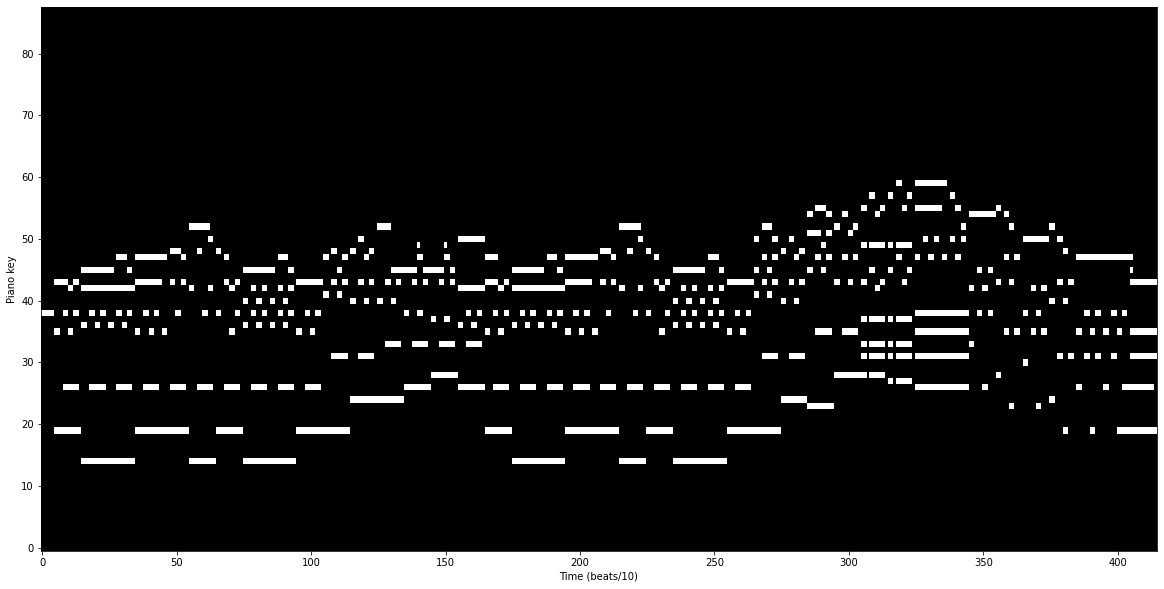

In [40]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(pianoroll.toarray(), origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({time_unit}s/{time_div})')
ax.set_ylabel('Piano key' if piano_range else 'MIDI pitch')
plt.show()

In some cases, we want to know the "coordinates" of each of the notes in the piano roll. The `compute_pianoroll` method includes an option to return 

In [41]:
pianoroll, note_indices = pt.utils.compute_pianoroll(score_part, return_idxs=True)

# MIDI pitch, start, end
print(note_indices[:5])

[[59  0  4]
 [40  4 12]
 [40  4  6]
 [56  4  6]
 [64  4  8]]


#### Generating a note array from a piano roll

Partitura also includes a method to generate a note array from a piano roll, which can be used to generate a MIDI file. 
This method would be useful, e.g., for music generation tasks

In [42]:
pianoroll = pt.utils.compute_pianoroll(score_part)

new_note_array = pt.utils.pianoroll_to_notearray(pianoroll)

# We can export the note array to a MIDI file
ppart = pt.performance.PerformedPart.from_note_array(new_note_array)

pt.save_performance_midi(ppart, "newmidi.mid")

## 5. Handling Alignment Information (Match files)

### 5.1 Loading Alignments
An important use case of partitura is to handle symbolic alignment information

**Note that partitura itself does not contain methods for alignment**

Partitura supports 2 formats for encoding score-to-performance alignments

* Our match file format, introduced by Gerhard et al. ;)
    * Datasets including match files: Vienna4x22, Magaloff, Zeilinger, Batik, and soon ASAP!
* The format introduced by [Nakamura et al. (2017)](https://eita-nakamura.github.io/articles/EN_etal_ErrorDetectionAndRealignment_ISMIR2017.pdf)

Let's load an alignment!

We have two common use cases

* We have both the match file and the symbolic score file (e.g., MusicXML or MEI)
* We have only the match file (only works for our format!)

#### 5.1.1. Loading an alignment if we only have a match file

A useful property of match files is that they include information about the **score and the performance**. Therefore, it is possible to create both a  `Part` and a `PerformedPart` directly from a match file.

* Match files contain all information included in performances in MIDI files, i.e., a MIDI file could be reconstructed from a match file.

* Match files include all information information about pitch spelling and score position and duration of the notes in the score, as well as time and key signature information, and can encode some note-level markings, like accents. Nevertheless, it is important to note that the score information included in a match file is not necessarily complete. For example, match files do not generally include dynamics or tempo markings.

In [43]:
# path to the match
match_fn = os.path.join(MATCH_DIR, 'Chopin_op10_no3_p01.match')
# loading a match file
performed_part, alignment, score_part = pt.load_match(match_fn, create_part=True)

#### 5.1.2. Loading an alignment if we have both score and match files

In many cases, however, we have access to both the score and match files. Using the original score file has a few advantages:

* It ensures that the score information is correct. Generating a `Part` from a match file involves inferring information for non-note elements (e.g., start and end time of the measures, voice information, clefs, staves, etc.).
* If we want to load several performances of the same piece, we can load the score only once!

This should be the preferred way to get alignment information!

In [48]:
# path to the match
match_fn = os.path.join(MATCH_DIR, 'Chopin_op10_no3_p01.match')
# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')
# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)[0]

# loading a match file
performed_part, alignment = pt.load_match(match_fn)

Score-to-performance alignments are represented by lists of dictionaries, which contain the following keys:

* `label`

    * `'match'`: there is a performed note corresponding to a score note
    * `'insertion'`: the performed note does not correspond to any note in the score
    * `'deletion'`: there is no performed note corresponding to a note in the score
    * `'ornament'`: the performed note corresponds to the performance of an ornament (e.g., a trill). These notes are matched to the main note in the score. Not all alignments (in the datasets that we have) include ornamnets! Otherwise, ornaments are just treated as insertions.
* `score_id`: id of the note in the score (in the `Part` object) (only relevant for matches, deletions and ornaments)
* `performance_id`: Id of the note in the performance (in the `PerformedPart`) (only relevant for matches, insertions and ornaments)

In [49]:
alignment[:10]

[{'label': 'match', 'score_id': 'n1', 'performance_id': 0},
 {'label': 'match', 'score_id': 'n2', 'performance_id': 2},
 {'label': 'match', 'score_id': 'n3', 'performance_id': 3},
 {'label': 'match', 'score_id': 'n4', 'performance_id': 1},
 {'label': 'match', 'score_id': 'n5', 'performance_id': 5},
 {'label': 'match', 'score_id': 'n6', 'performance_id': 4},
 {'label': 'match', 'score_id': 'n7', 'performance_id': 6},
 {'label': 'match', 'score_id': 'n8', 'performance_id': 7},
 {'label': 'match', 'score_id': 'n9', 'performance_id': 8},
 {'label': 'match', 'score_id': 'n10', 'performance_id': 9}]

### 5.2 Getting information from the alignments

Partitura includes a few methods for getting information from the alignments.

Let's start by getting the subset of score notes that have a corresponding performed note

In [50]:
# note array of the score
snote_array = score_part.note_array()
# note array of the performance
pnote_array = performed_part.note_array()
# indices of the notes that have been matched
matched_note_idxs = pt.utils.music.get_matched_notes(snote_array, pnote_array, alignment)

# note array of the matched score notes
matched_snote_array = snote_array[matched_note_idxs[:, 0]]
# note array of the matched performed notes
matched_pnote_array = pnote_array[matched_note_idxs[:, 1]]

#### Comparing tempo curves

In this example, we are going to compare tempo curves of different performances of the same piece. Partitura includes a utility function called `get_time_maps_from_alignment`which creates functions (instances of [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)) that map score time to performance time (and the other way around).

In [54]:
# get all match files
matchfiles = glob.glob(os.path.join(MATCH_DIR, 'Chopin_op10_no3_p*.match'))
matchfiles.sort()

# Score time from the first to the last onset
score_time = np.linspace(snote_array['onset_beat'].min(),
                         snote_array['onset_beat'].max(),
                         100)
# Include the last offset
score_time_ending = np.r_[
    score_time, 
    (snote_array['onset_beat'] + snote_array['duration_beat']).max() # last offset
]

tempo_curves = np.zeros((len(matchfiles), len(score_time)))
for i, matchfile in enumerate(matchfiles):
    # load alignment
    performance, alignment = pt.load_match(matchfile)
    ppart = performance[0]
    # Get score time to performance time map
    _, stime_to_ptime_map = pt.utils.music.get_time_maps_from_alignment(
        ppart, score_part, alignment)
    # Compute naïve tempo curve
    performance_time = stime_to_ptime_map(score_time_ending)
    tempo_curves[i,:] = 60 * np.diff(score_time_ending) / np.diff(performance_time)

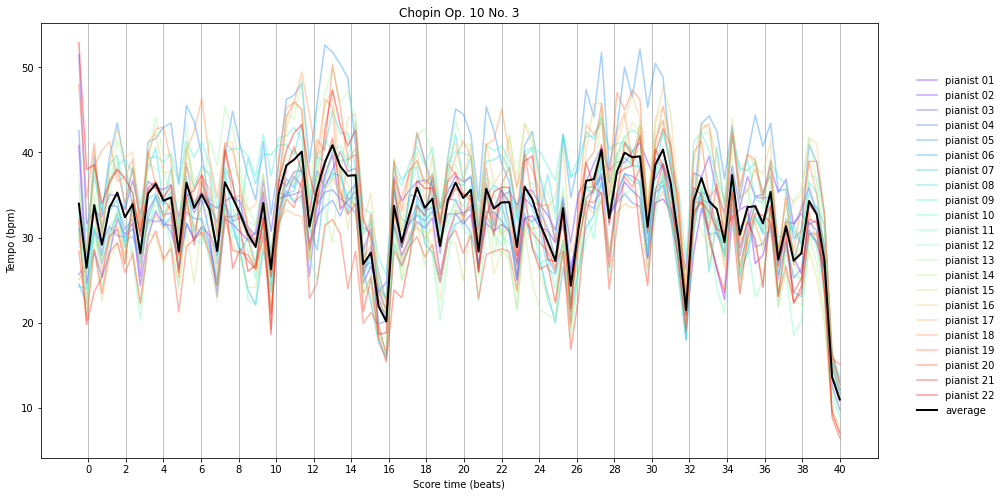

In [55]:
fig, ax = plt.subplots(1, figsize=(15, 8))
color = plt.cm.rainbow(np.linspace(0, 1, len(tempo_curves)))
for i, tempo_curve in enumerate(tempo_curves):
    ax.plot(score_time, tempo_curve, 
            label=f'pianist {i + 1:02d}', alpha=0.4, c=color[i])

# plot average performance
ax.plot(score_time, tempo_curves.mean(0), label='average', c='black', linewidth=2)

# get starting time of each measure in the score
measure_times = score_part.beat_map([measure.start.t for measure in score_part.iter_all(pt.score.Measure)])
# do not include pickup measure
measure_times = measure_times[measure_times >= 0]
ax.set_title('Chopin Op. 10 No. 3')
ax.set_xlabel('Score time (beats)')
ax.set_ylabel('Tempo (bpm)')
ax.set_xticks(measure_times)
plt.legend(frameon=False, bbox_to_anchor = (1.15, .9))
plt.grid(axis='x')
plt.show()

## The end of the tutorial, the start of your yet untold adventures in symbolic music processing...

Thank you for trying out partitura! We hope it serves you well. 

If you miss a particular functionality or encounter a bug, we appreciate it if you raise an issue on github: https://github.com/CPJKU/partitura/issues